# Loading necessary libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Loading and preprocessing images

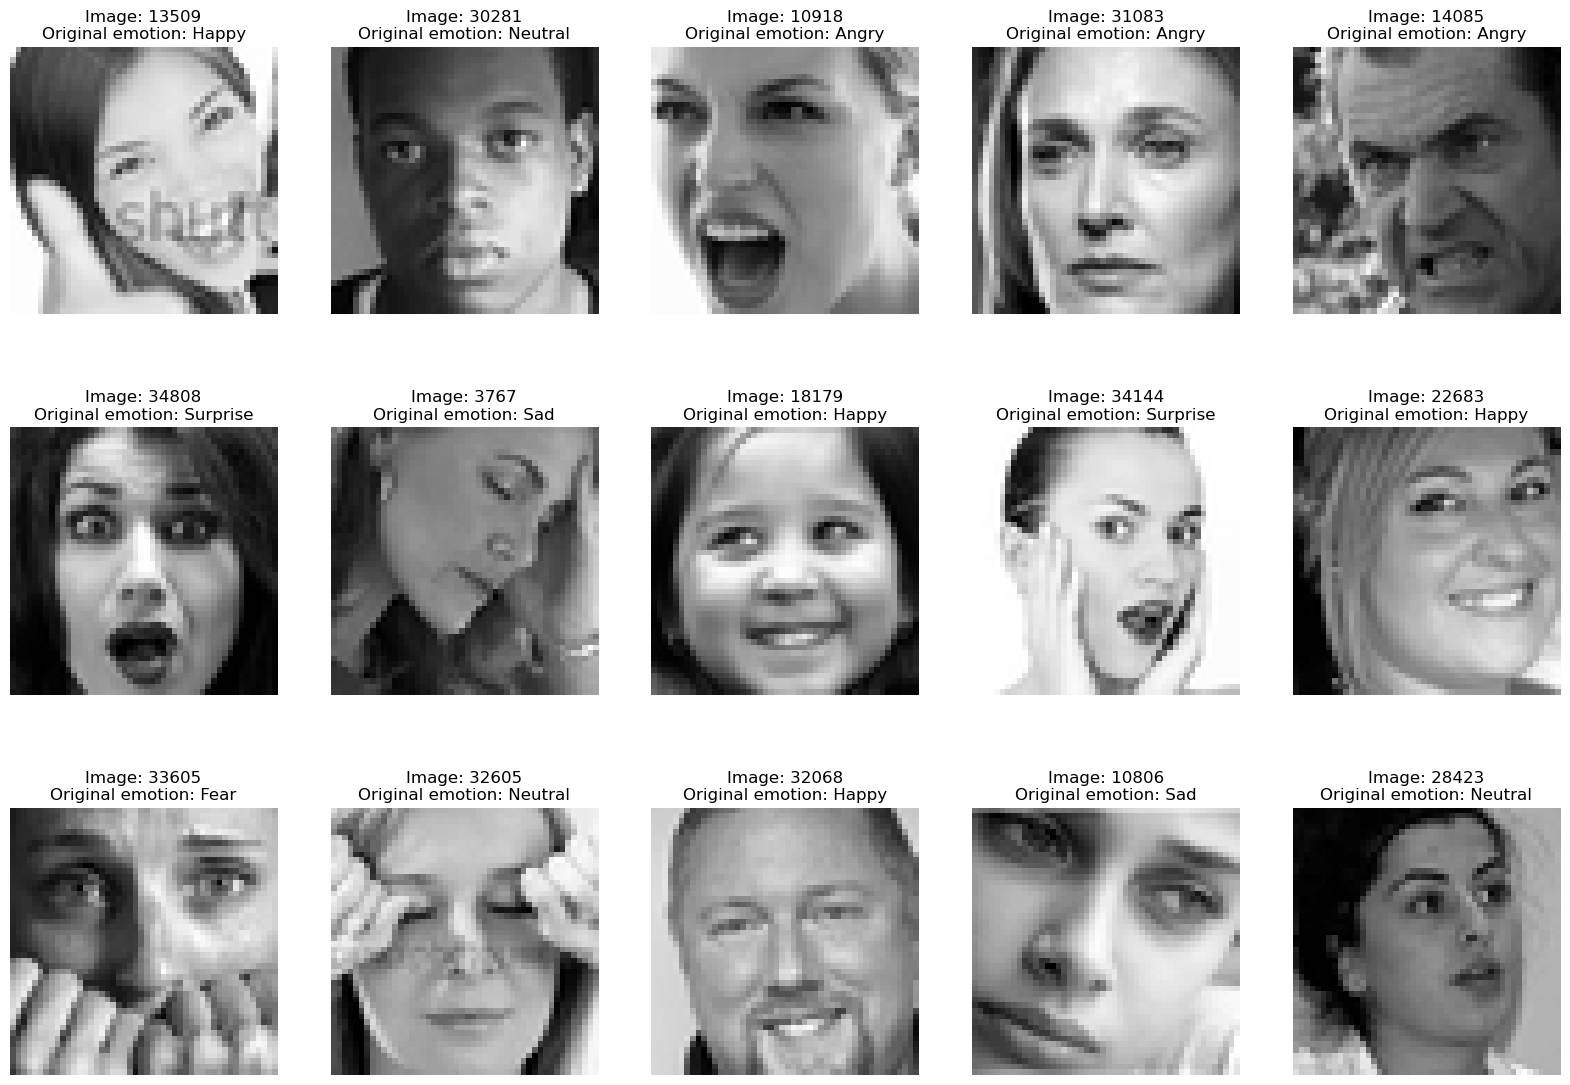

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv("../fer2013.csv")

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()]).tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(float)


test_idx_start = 32298
images_test = images[test_idx_start:]


# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org=None, emotion_nms_pred=None, random=True, indices=None):
    """ 
    Function displaying 15 randomly chosen images. Arguments:
    imgs:  Source of images
    emotion_nms_org: Default "None", if specified, should be a Pandas Series object consisting of emotion names.
    As a result, emotion name will be displayed above every image.
    emotion_nms_pred: Default "None", if specified should be a Pandas Series object with predicted emotion names.
    As a result, emotion name will be displayed above image.
    random: Default "True", indices will be randomly drawn from “discrete uniform” distribution starting at 0 up to max(len(imgs)) otherwise randomly chosen from values passed into "indices" argument without replacement.
    indices: Default "None", if specified "random" should be set to "False" to draw random images from the variable passed into "indices" argument starting at min(len(indices)) up to max(len(indices)) and not using "discrete uniform" distribution.
    """
    if random:
        indices = np.random.randint(0, len(imgs), size=15)
    else:
        indices = np.random.choice(list(indices), size=15, replace=False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3, 5, index + 1)
        if (emotion_nms_org is None and emotion_nms_pred is None):
            plt.title('Image: ' + str(indices[index]))           
        elif (emotion_nms_org is None and emotion_nms_pred is not None):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (emotion_nms_org is not None and emotion_nms_pred is None):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48, 48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')


show_random(images, emotion_nms_org=data['emotion_name'])

# Standardizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images, each_pixel_mean), each_pixel_std)

image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]


# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)


In [15]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

# Building CNN

In [16]:
# Constructing CNN structure
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        3

# Training CNN using Data Augmentation

In [22]:
# Compiling model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='Model.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=300,  # Mengganti nb_epoch menjadi epochs
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0] // 32,  # Menggunakan // untuk pembagian bulat
                    callbacks=[checkpointer, tensorboard]
                              )



pd.DataFrame(history.history).to_csv("history.csv")

Epoch 1/300


C:\Users\hp\AppData\Local\Temp\ipykernel_3088\3383708192.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train,


907/908 [============================>.] - ETA: 0s - loss: 1.7930 - accuracy: 0.2547
Epoch 1: val_loss improved from inf to 4.18227, saving model to Model.hdf5
908/908 [==============================] - 16s 16ms/step - loss: 1.7929 - accuracy: 0.2547 - val_loss: 4.1823 - val_accuracy: 0.2545
Epoch 2/300
907/908 [============================>.] - ETA: 0s - loss: 1.7805 - accuracy: 0.2618
Epoch 2: val_loss improved from 4.18227 to 3.57343, saving model to Model.hdf5
908/908 [==============================] - 14s 16ms/step - loss: 1.7804 - accuracy: 0.2618 - val_loss: 3.5734 - val_accuracy: 0.2706
Epoch 3/300
908/908 [==============================] - ETA: 0s - loss: 1.7667 - accuracy: 0.2688
Epoch 3: val_loss did not improve from 3.57343
908/908 [==============================] - 15s 16ms/step - loss: 1.7667 - accuracy: 0.2688 - val_loss: 4.0233 - val_accuracy: 0.2461
Epoch 4/300
905/908 [============================>.] - ETA: 0s - loss: 1.7557 - accuracy: 0.2739
Epoch 4: val_loss did no

Epoch 29/300
908/908 [==============================] - ETA: 0s - loss: 1.4247 - accuracy: 0.4497
Epoch 29: val_loss improved from 1.31549 to 1.25929, saving model to Model.hdf5
908/908 [==============================] - 16s 18ms/step - loss: 1.4247 - accuracy: 0.4497 - val_loss: 1.2593 - val_accuracy: 0.5164
Epoch 30/300
906/908 [============================>.] - ETA: 0s - loss: 1.4009 - accuracy: 0.4632
Epoch 30: val_loss did not improve from 1.25929
908/908 [==============================] - 16s 18ms/step - loss: 1.4010 - accuracy: 0.4631 - val_loss: 1.2863 - val_accuracy: 0.5115
Epoch 31/300
908/908 [==============================] - ETA: 0s - loss: 1.3946 - accuracy: 0.4629
Epoch 31: val_loss did not improve from 1.25929
908/908 [==============================] - 16s 18ms/step - loss: 1.3946 - accuracy: 0.4629 - val_loss: 1.2957 - val_accuracy: 0.5238
Epoch 32/300
907/908 [============================>.] - ETA: 0s - loss: 1.3795 - accuracy: 0.4681
Epoch 32: val_loss did not improv

908/908 [==============================] - ETA: 0s - loss: 1.2074 - accuracy: 0.5401
Epoch 57: val_loss improved from 1.13202 to 1.12690, saving model to Model.hdf5
908/908 [==============================] - 16s 18ms/step - loss: 1.2074 - accuracy: 0.5401 - val_loss: 1.1269 - val_accuracy: 0.5709
Epoch 58/300
907/908 [============================>.] - ETA: 0s - loss: 1.1964 - accuracy: 0.5480
Epoch 58: val_loss did not improve from 1.12690
908/908 [==============================] - 17s 19ms/step - loss: 1.1964 - accuracy: 0.5480 - val_loss: 1.1582 - val_accuracy: 0.5684
Epoch 59/300
907/908 [============================>.] - ETA: 0s - loss: 1.1978 - accuracy: 0.5471
Epoch 59: val_loss improved from 1.12690 to 1.11914, saving model to Model.hdf5
908/908 [==============================] - 17s 18ms/step - loss: 1.1975 - accuracy: 0.5473 - val_loss: 1.1191 - val_accuracy: 0.5836
Epoch 60/300
906/908 [============================>.] - ETA: 0s - loss: 1.1935 - accuracy: 0.5465
Epoch 60: val_

908/908 [==============================] - 17s 18ms/step - loss: 1.1157 - accuracy: 0.5786 - val_loss: 1.0661 - val_accuracy: 0.5972
Epoch 86/300
908/908 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.5830
Epoch 86: val_loss did not improve from 1.04815
908/908 [==============================] - 16s 18ms/step - loss: 1.1111 - accuracy: 0.5830 - val_loss: 1.0895 - val_accuracy: 0.5926
Epoch 87/300
907/908 [============================>.] - ETA: 0s - loss: 1.1097 - accuracy: 0.5814
Epoch 87: val_loss did not improve from 1.04815
908/908 [==============================] - 16s 18ms/step - loss: 1.1099 - accuracy: 0.5813 - val_loss: 1.0513 - val_accuracy: 0.6006
Epoch 88/300
908/908 [==============================] - ETA: 0s - loss: 1.1106 - accuracy: 0.5814
Epoch 88: val_loss did not improve from 1.04815
908/908 [==============================] - 16s 18ms/step - loss: 1.1106 - accuracy: 0.5814 - val_loss: 1.0538 - val_accuracy: 0.6077
Epoch 89/300
905/908 [========

908/908 [==============================] - 17s 18ms/step - loss: 1.0614 - accuracy: 0.6049 - val_loss: 1.0273 - val_accuracy: 0.6074
Epoch 115/300
906/908 [============================>.] - ETA: 0s - loss: 1.0633 - accuracy: 0.6034
Epoch 115: val_loss did not improve from 1.01889
908/908 [==============================] - 16s 18ms/step - loss: 1.0630 - accuracy: 0.6036 - val_loss: 1.0446 - val_accuracy: 0.6037
Epoch 116/300
908/908 [==============================] - ETA: 0s - loss: 1.0605 - accuracy: 0.6008
Epoch 116: val_loss did not improve from 1.01889
908/908 [==============================] - 16s 18ms/step - loss: 1.0605 - accuracy: 0.6008 - val_loss: 1.0455 - val_accuracy: 0.6059
Epoch 117/300
906/908 [============================>.] - ETA: 0s - loss: 1.0538 - accuracy: 0.6037
Epoch 117: val_loss did not improve from 1.01889
908/908 [==============================] - 17s 19ms/step - loss: 1.0540 - accuracy: 0.6037 - val_loss: 1.0289 - val_accuracy: 0.6173
Epoch 118/300
908/908 [=

906/908 [============================>.] - ETA: 0s - loss: 1.0216 - accuracy: 0.6178
Epoch 143: val_loss did not improve from 0.99047
908/908 [==============================] - 17s 19ms/step - loss: 1.0216 - accuracy: 0.6179 - val_loss: 1.0152 - val_accuracy: 0.6158
Epoch 144/300
906/908 [============================>.] - ETA: 0s - loss: 1.0164 - accuracy: 0.6178
Epoch 144: val_loss did not improve from 0.99047
908/908 [==============================] - 17s 18ms/step - loss: 1.0163 - accuracy: 0.6178 - val_loss: 1.0075 - val_accuracy: 0.6266
Epoch 145/300
905/908 [============================>.] - ETA: 0s - loss: 1.0212 - accuracy: 0.6164
Epoch 145: val_loss improved from 0.99047 to 0.98690, saving model to Model.hdf5
908/908 [==============================] - 17s 18ms/step - loss: 1.0215 - accuracy: 0.6162 - val_loss: 0.9869 - val_accuracy: 0.6241
Epoch 146/300
906/908 [============================>.] - ETA: 0s - loss: 1.0222 - accuracy: 0.6193
Epoch 146: val_loss did not improve from

Epoch 172/300
906/908 [============================>.] - ETA: 0s - loss: 0.9881 - accuracy: 0.6284
Epoch 172: val_loss did not improve from 0.97900
908/908 [==============================] - 18s 19ms/step - loss: 0.9879 - accuracy: 0.6285 - val_loss: 0.9897 - val_accuracy: 0.6384
Epoch 173/300
906/908 [============================>.] - ETA: 0s - loss: 0.9923 - accuracy: 0.6330
Epoch 173: val_loss did not improve from 0.97900
908/908 [==============================] - 16s 18ms/step - loss: 0.9923 - accuracy: 0.6331 - val_loss: 1.0293 - val_accuracy: 0.6279
Epoch 174/300
908/908 [==============================] - ETA: 0s - loss: 0.9909 - accuracy: 0.6307
Epoch 174: val_loss did not improve from 0.97900
908/908 [==============================] - 17s 18ms/step - loss: 0.9909 - accuracy: 0.6307 - val_loss: 0.9825 - val_accuracy: 0.6322
Epoch 175/300
908/908 [==============================] - ETA: 0s - loss: 0.9970 - accuracy: 0.6293
Epoch 175: val_loss did not improve from 0.97900
908/908 [

906/908 [============================>.] - ETA: 0s - loss: 0.9670 - accuracy: 0.6413
Epoch 201: val_loss did not improve from 0.97685
908/908 [==============================] - 16s 18ms/step - loss: 0.9672 - accuracy: 0.6413 - val_loss: 1.0333 - val_accuracy: 0.6322
Epoch 202/300
906/908 [============================>.] - ETA: 0s - loss: 0.9638 - accuracy: 0.6417
Epoch 202: val_loss did not improve from 0.97685
908/908 [==============================] - 17s 18ms/step - loss: 0.9641 - accuracy: 0.6417 - val_loss: 1.0064 - val_accuracy: 0.6402
Epoch 203/300
906/908 [============================>.] - ETA: 0s - loss: 0.9644 - accuracy: 0.6389
Epoch 203: val_loss did not improve from 0.97685
908/908 [==============================] - 17s 19ms/step - loss: 0.9646 - accuracy: 0.6389 - val_loss: 1.0226 - val_accuracy: 0.6341
Epoch 204/300
906/908 [============================>.] - ETA: 0s - loss: 0.9677 - accuracy: 0.6397
Epoch 204: val_loss did not improve from 0.97685
908/908 [==============

906/908 [============================>.] - ETA: 0s - loss: 0.9509 - accuracy: 0.6438
Epoch 230: val_loss did not improve from 0.96427
908/908 [==============================] - 17s 18ms/step - loss: 0.9507 - accuracy: 0.6440 - val_loss: 0.9897 - val_accuracy: 0.6344
Epoch 231/300
907/908 [============================>.] - ETA: 0s - loss: 0.9492 - accuracy: 0.6474
Epoch 231: val_loss did not improve from 0.96427
908/908 [==============================] - 17s 18ms/step - loss: 0.9489 - accuracy: 0.6473 - val_loss: 0.9923 - val_accuracy: 0.6384
Epoch 232/300
907/908 [============================>.] - ETA: 0s - loss: 0.9480 - accuracy: 0.6489
Epoch 232: val_loss did not improve from 0.96427
908/908 [==============================] - 17s 18ms/step - loss: 0.9478 - accuracy: 0.6490 - val_loss: 0.9930 - val_accuracy: 0.6492
Epoch 233/300
908/908 [==============================] - ETA: 0s - loss: 0.9458 - accuracy: 0.6476
Epoch 233: val_loss did not improve from 0.96427
908/908 [==============

905/908 [============================>.] - ETA: 0s - loss: 0.9325 - accuracy: 0.6520
Epoch 259: val_loss did not improve from 0.96427
908/908 [==============================] - 16s 18ms/step - loss: 0.9326 - accuracy: 0.6520 - val_loss: 1.0260 - val_accuracy: 0.6393
Epoch 260/300
905/908 [============================>.] - ETA: 0s - loss: 0.9332 - accuracy: 0.6550
Epoch 260: val_loss did not improve from 0.96427
908/908 [==============================] - 17s 18ms/step - loss: 0.9338 - accuracy: 0.6548 - val_loss: 1.0531 - val_accuracy: 0.6322
Epoch 261/300
907/908 [============================>.] - ETA: 0s - loss: 0.9251 - accuracy: 0.6524
Epoch 261: val_loss did not improve from 0.96427
908/908 [==============================] - 17s 18ms/step - loss: 0.9249 - accuracy: 0.6525 - val_loss: 0.9879 - val_accuracy: 0.6387
Epoch 262/300
908/908 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.6529
Epoch 262: val_loss did not improve from 0.96427
908/908 [==============

Epoch 288/300
908/908 [==============================] - ETA: 0s - loss: 0.9196 - accuracy: 0.6577
Epoch 288: val_loss did not improve from 0.96394
908/908 [==============================] - 16s 18ms/step - loss: 0.9196 - accuracy: 0.6577 - val_loss: 0.9957 - val_accuracy: 0.6461
Epoch 289/300
905/908 [============================>.] - ETA: 0s - loss: 0.9134 - accuracy: 0.6609
Epoch 289: val_loss did not improve from 0.96394
908/908 [==============================] - 17s 18ms/step - loss: 0.9135 - accuracy: 0.6609 - val_loss: 1.0361 - val_accuracy: 0.6421
Epoch 290/300
907/908 [============================>.] - ETA: 0s - loss: 0.9215 - accuracy: 0.6619
Epoch 290: val_loss did not improve from 0.96394
908/908 [==============================] - 17s 18ms/step - loss: 0.9213 - accuracy: 0.6619 - val_loss: 0.9877 - val_accuracy: 0.6297
Epoch 291/300
907/908 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.6597
Epoch 291: val_loss did not improve from 0.96394
908/908 [

# Loading best model and exploring the results

In [25]:
# model2 = load_model('Best_model_6759OffTest.hdf5')

In [26]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=64)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))

57/57 [==============================] - 1s 11ms/step - loss: 0.9610 - accuracy: 0.6615
Loss: 0.9609518647193909
Accuracy: 0.661465585231781


In [28]:
history = pd.read_csv('history.csv')


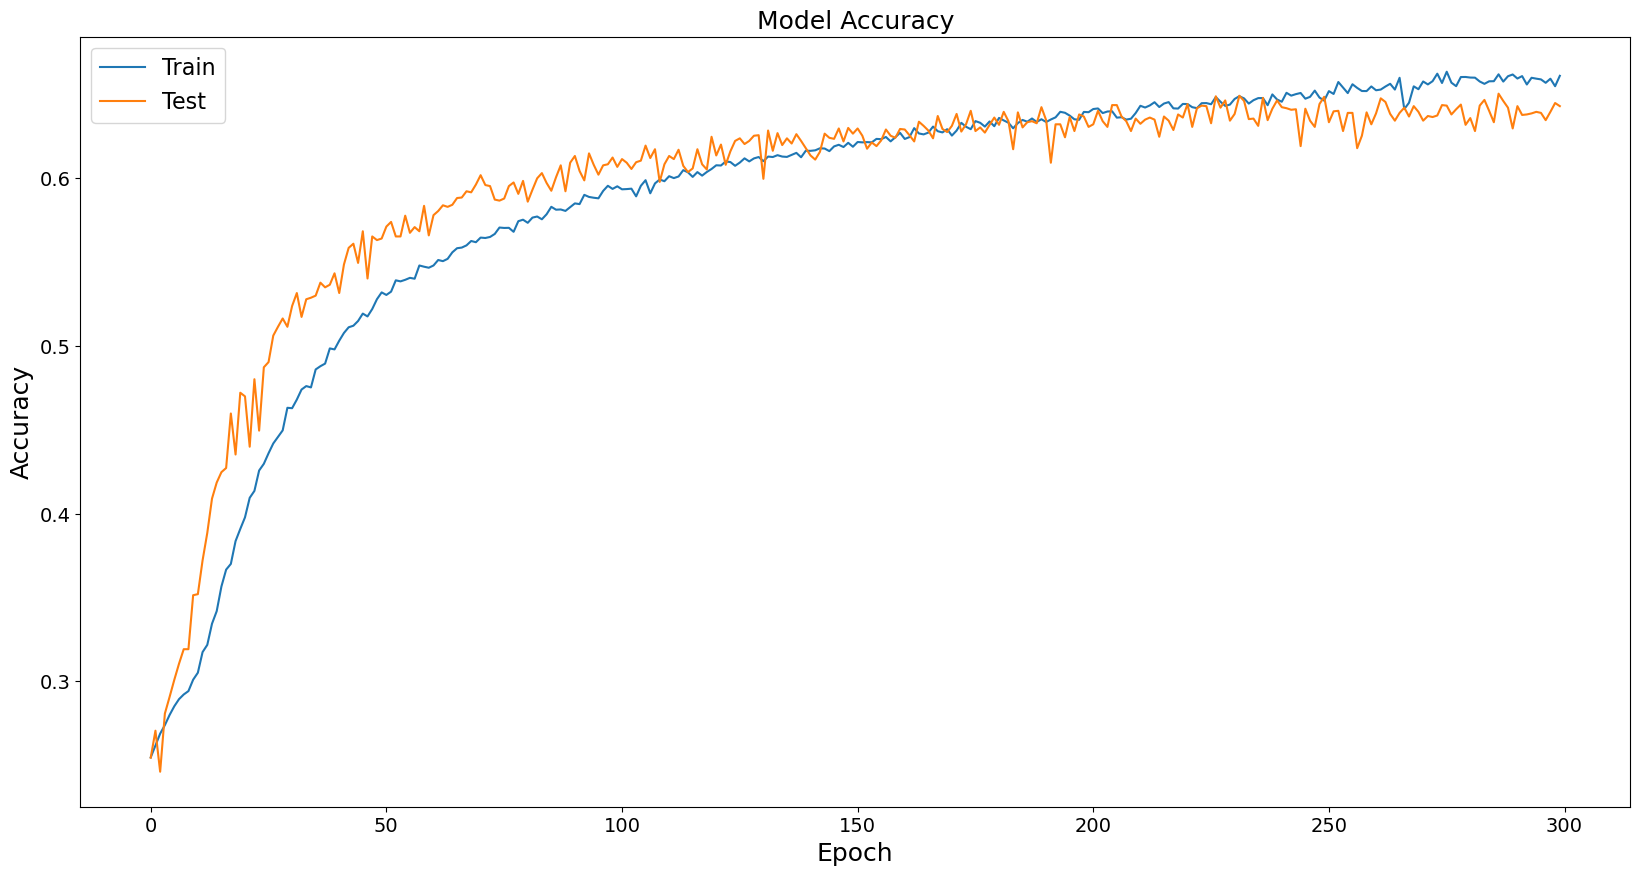

In [31]:
def plot_accuracy(data, size=(20, 10)):
    plt.figure(figsize=size) 
    plt.plot(data['accuracy'])  # Menggunakan 'accuracy'
    plt.plot(data['val_accuracy'])  # Menggunakan 'val_accuracy'
    plt.title('Model Accuracy', fontsize=18)
    plt.xlabel('Epoch', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize=16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

plot_accuracy(history)

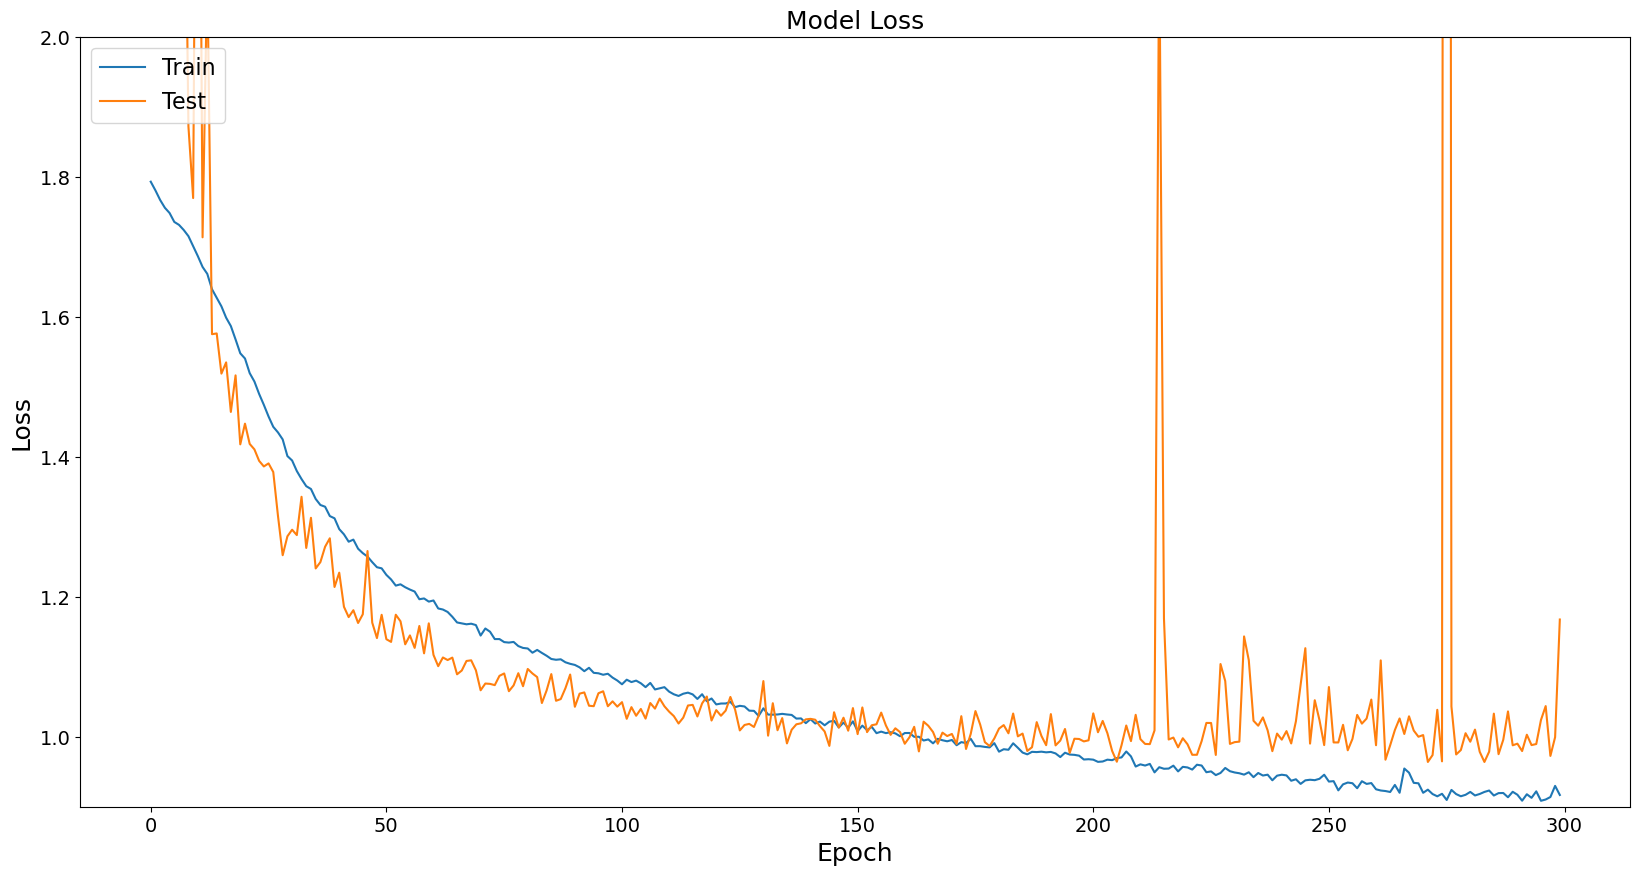

In [32]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)

In [33]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results


def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

In [36]:
correct, results_df = predict_classes(model, X_test, y_test, emotions_names, batch_size = 64)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

57/57 [==============================] - 1s 13ms/step


### Correctly predicted images

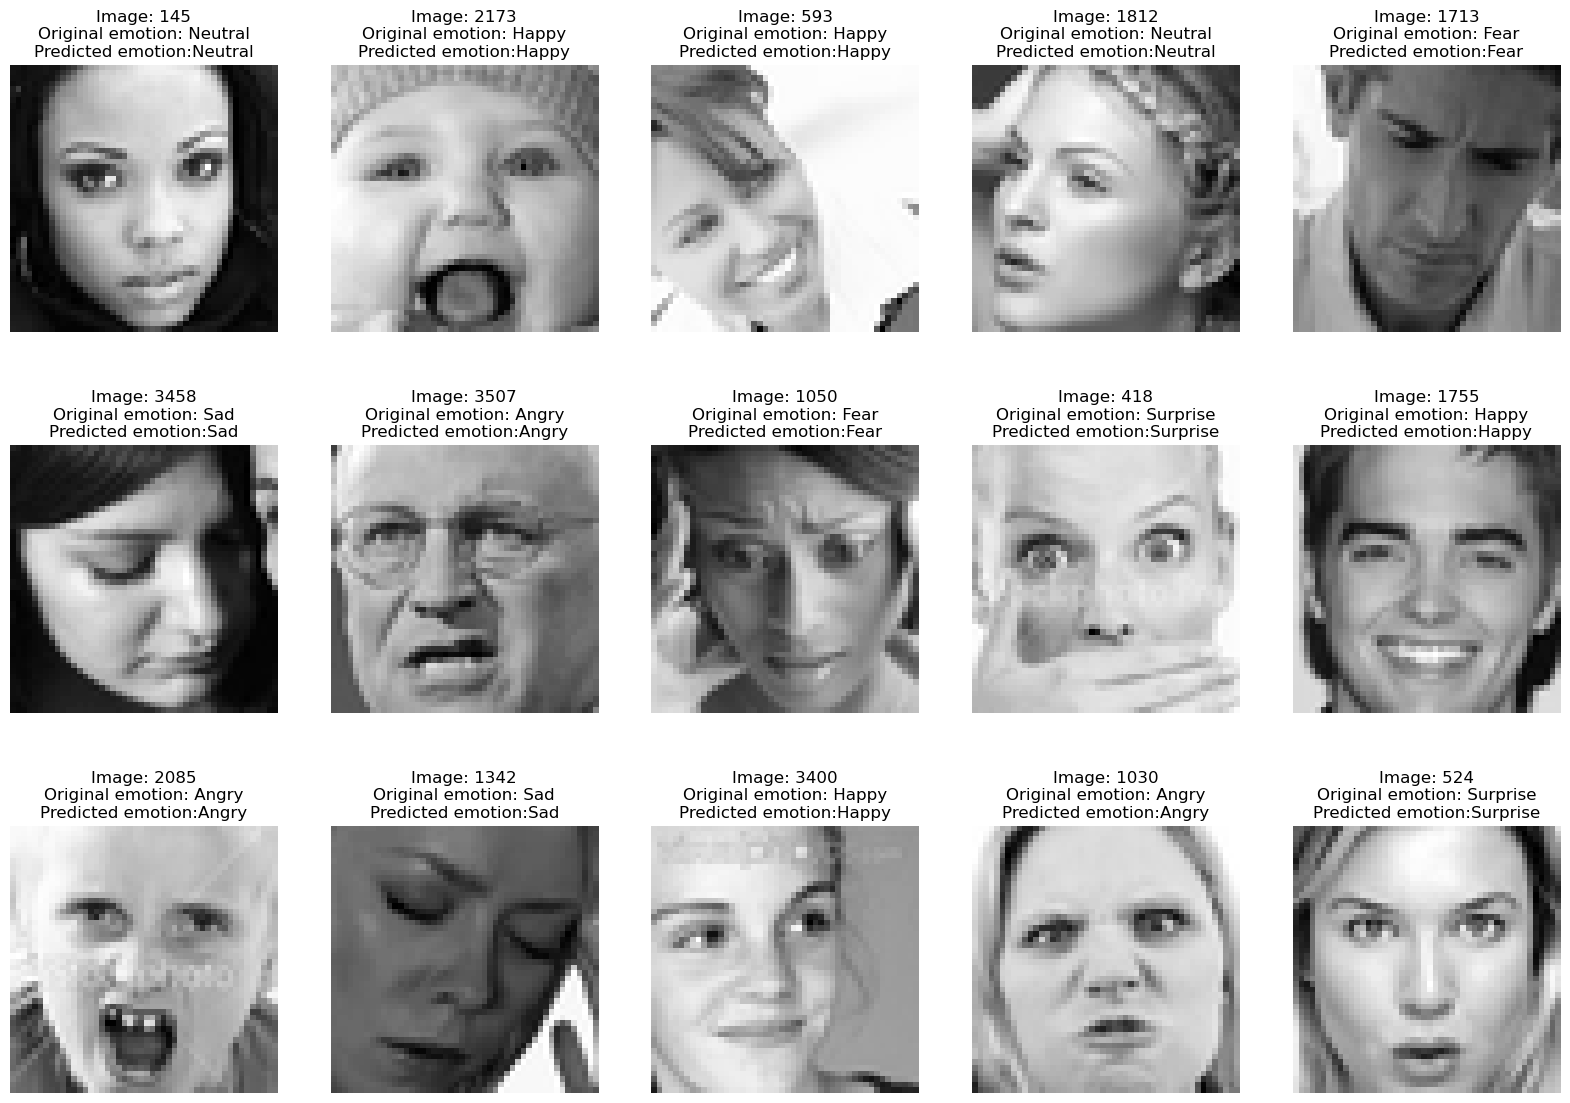

In [37]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = True)

### Wronly predicted images

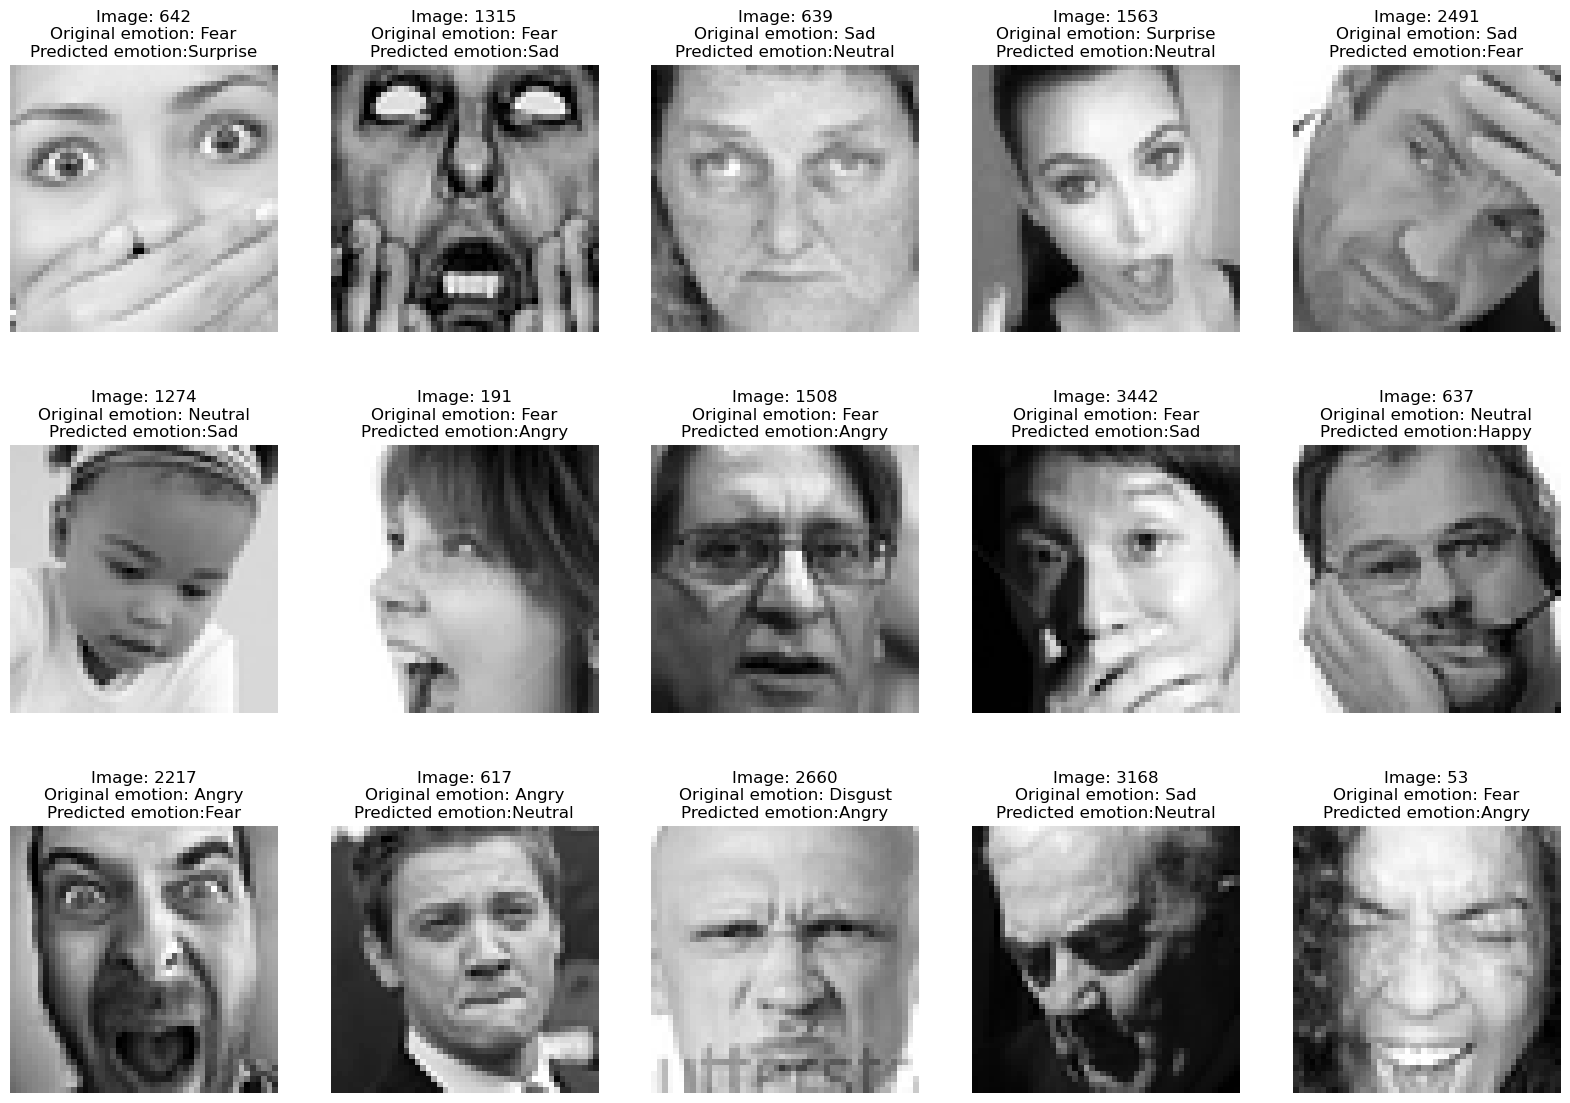

In [38]:
visualize_predictions(images_test, results_df['True_emotion'], results_df['Predicted_emotion'], correct, valid = False)

### Confusion matrix

In [39]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

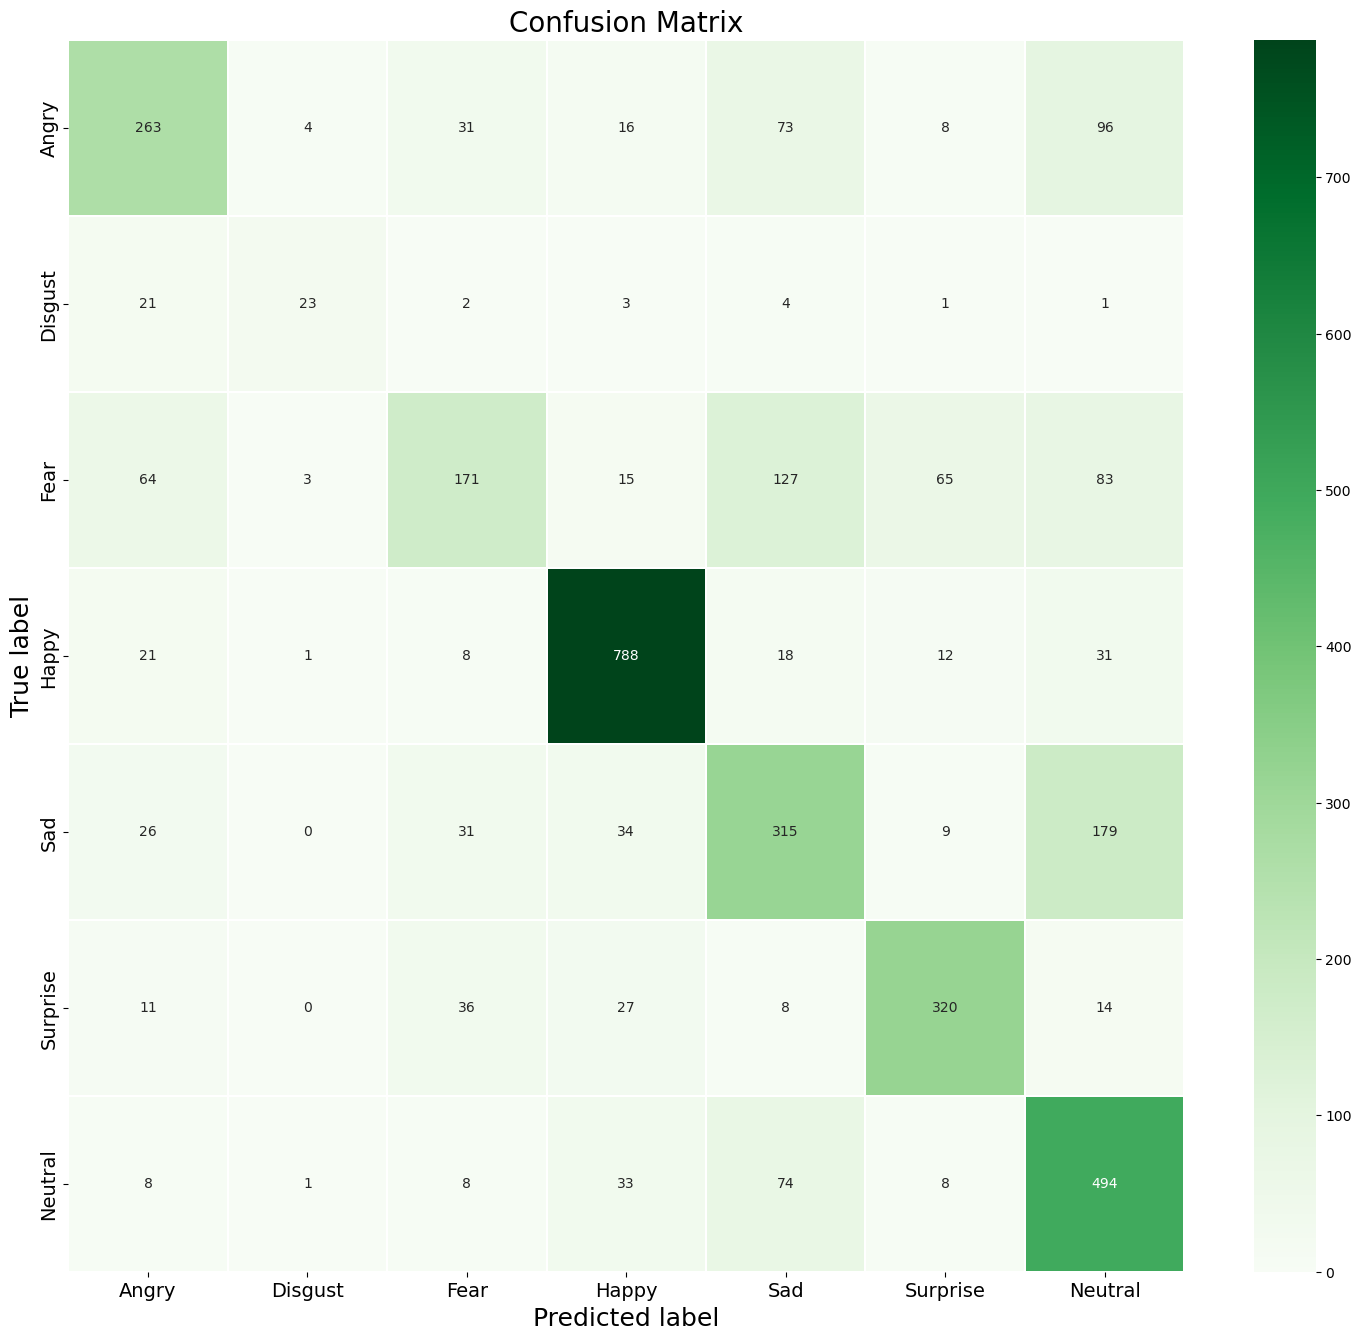

In [40]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], colour = 'Greens')